In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations for CIFAR-10 data
transform = transforms.Compose([
    transforms.Resize(224),  # Resize to match ImageNet models input size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15867710.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


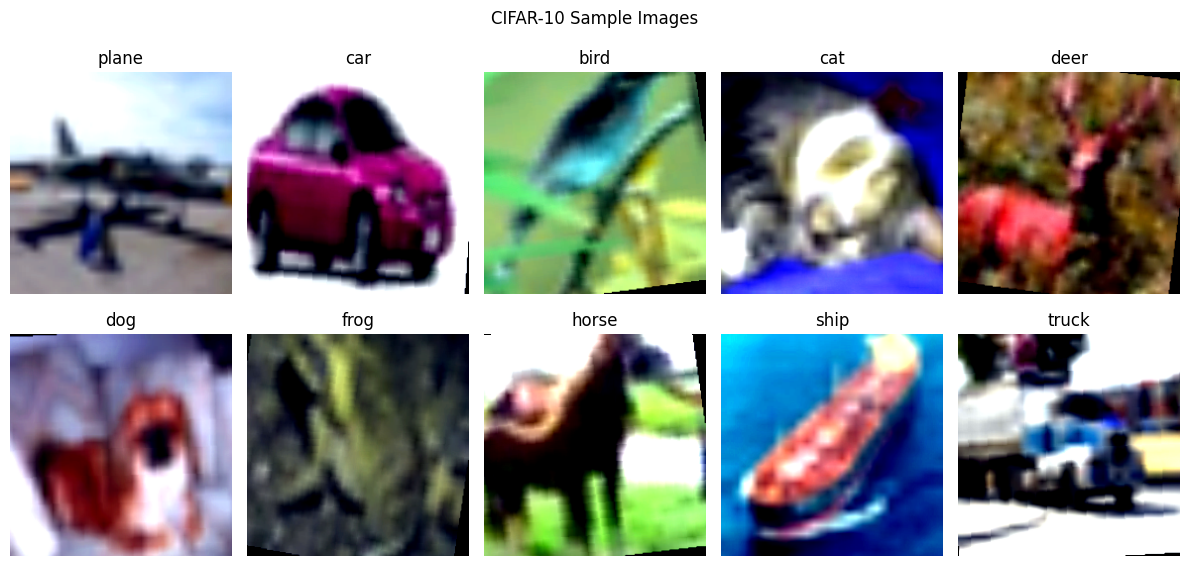

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Define the CIFAR-10 classes
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a figure to display images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # 2 rows and 5 columns
fig.suptitle('CIFAR-10 Sample Images')

# Display one image from each class
for i in range(10):
    ax = axes[i // 5, i % 5]  # Get the appropriate subplot
    ax.imshow(np.transpose(images[labels == i][0], (1, 2, 0)) / 2 + 0.5)  # Show the first image of the class
    ax.set_title(classes[i])  # Set the title to the class name
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

In [3]:
# Function to calculate accuracy and validation loss
def calculate_accuracy_and_loss(loader, model, criterion):
    correct = 0
    total = 0
    val_loss = 0.0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    avg_val_loss = val_loss / len(loader)
    return accuracy, avg_val_loss

In [4]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        score = val_acc

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0  # Reset counter if validation accuracy improves

In [5]:
# Define function to train the model
def train_model(model, criterion, optimizer, num_epochs=10, patience=3):
    model.to(device)
    early_stopping = EarlyStopping(patience=patience)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Use tqdm to track progress
        loop = tqdm(trainloader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Update tqdm progress bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=running_loss/len(loop), acc=100.*correct/total)

        # Calculate training accuracy
        train_acc = 100. * correct / total

        # Calculate validation accuracy and loss
        valid_acc, valid_loss = calculate_accuracy_and_loss(testloader, model, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}, "
              f"Train Accuracy: {train_acc}%, Validation Accuracy: {valid_acc}%, Validation Loss: {valid_loss}")

        # Check early stopping
        early_stopping(valid_acc)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print('Finished Training')


In [6]:
import torch
import torch.nn as nn
from torchsummary import summary

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Conv layer with 16 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Conv layer with 32 channels
        self.pool = nn.MaxPool2d(2, 2)  # MaxPool layer with 2x2 kernel
        self.fc1 = nn.Linear(32 * 56 * 56, 512)  # Fully connected layer, output 512
        self.fc2 = nn.Linear(512, 10)  # Fully connected layer, output 10 (CIFAR-10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 + ReLU + Pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 + ReLU + Pooling
        x = x.view(-1, 32 * 56 * 56)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # Fully connected layer + ReLU
        x = self.fc2(x)  # Output layer
        return x


In [7]:
input_size = (3, 224, 224)  # CIFAR-10 images will be resized to 224x224

print(f"Model: Baseline")
summary(SimpleCNN(), input_size=input_size)

Model: Baseline
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 512]      51,380,736
            Linear-6                   [-1, 10]           5,130
Total params: 51,390,954
Trainable params: 51,390,954
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 196.04
Estimated Total Size (MB): 208.10
----------------------------------------------------------------


In [19]:
# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()

baseline = SimpleCNN()

print(f"\nTraining baseline model...")
optimizer = optim.SGD(baseline.parameters(), lr=0.001, momentum=0.9)
train_model(baseline, criterion, optimizer)

Training baseline model...
Epoch 1/10, Loss: 1.6438217309429823, Train Accuracy: 42.056%, Validation Accuracy: 49.1%, Validation Loss: 1.4376929785795272
Epoch 2/10, Loss: 1.3787736257018945, Train Accuracy: 51.33%, Validation Accuracy: 52.77%, Validation Loss: 1.3325094288321817
Epoch 3/10, Loss: 1.2525176470694335, Train Accuracy: 55.638%, Validation Accuracy: 55.2%, Validation Loss: 1.254836335303677
Epoch 4/10, Loss: 1.1488344973462927, Train Accuracy: 59.528%, Validation Accuracy: 56.03%, Validation Loss: 1.234104012607769
Epoch 5/10, Loss: 1.0562157462472501, Train Accuracy: 63.006%, Validation Accuracy: 57.5%, Validation Loss: 1.1969839748303601
Epoch 6/10, Loss: 0.9539979111660472, Train Accuracy: 66.736%, Validation Accuracy: 58.67%, Validation Loss: 1.185196512444004
Epoch 7/10, Loss: 0.8524077502662873, Train Accuracy: 70.368%, Validation Accuracy: 59.8%, Validation Loss: 1.1589522483242545
Epoch 8/10, Loss: 0.7472911583416907, Train Accuracy: 73.868%, Validation Accuracy: 6

In [8]:
# Model list: VGG16, VGG19, ResNet18, ResNet34, ResNet50
models_list = {
    'ResNet18': models.resnet18(pretrained=True),
    'ResNet34': models.resnet34(pretrained=True),
    'ResNet50': models.resnet50(pretrained=True),
    'VGG16': models.vgg16(pretrained=True),
    'VGG19': models.vgg19(pretrained=True)
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.5MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

In [9]:
# Print the summary for each model
input_size = (3, 224, 224)  # CIFAR-10 images will be resized to 224x224
for model_name, model in models_list.items():
    print(f"Model: {model_name}")
    summary(model, input_size=input_size)
    print("="*60)

Model: ResNet18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14   

In [ ]:
# Modify the final layer to match CIFAR-10's 10 classes
for model_name, model in models_list.items():
    if "vgg" in model_name.lower():
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # For VGG models
    else:
        model.fc = nn.Linear(model.fc.in_features, 10)  # For ResNet models

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()

# Train and evaluate all models
for model_name, model in models_list.items():
    print(f"\nTraining {model_name}...")
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    train_model(model, criterion, optimizer)


Training ResNet18...


Epoch 1/10, Loss: 0.47668695155426366, Train Accuracy: 84.976%, Validation Accuracy: 92.55%, Validation Loss: 0.2194991246530205


Epoch 2/10, Loss: 0.17385227402286305, Train Accuracy: 94.236%, Validation Accuracy: 94.07%, Validation Loss: 0.17671046790423667


Epoch 3/10, Loss: 0.101971233235029, Train Accuracy: 96.838%, Validation Accuracy: 94.24%, Validation Loss: 0.17245463917779316


Epoch 4/10, Loss: 0.06313689293094513, Train Accuracy: 98.174%, Validation Accuracy: 94.55%, Validation Loss: 0.15985232828908666


Epoch 5/10, Loss: 0.038544629218742785, Train Accuracy: 99.046%, Validation Accuracy: 94.93%, Validation Loss: 0.16250191691812058


Epoch 6/10, Loss: 0.02379645123485895, Train Accuracy: 99.578%, Validation Accuracy: 94.85%, Validation Loss: 0.16796384704340794
EarlyStopping counter: 1 out of 3


Epoch 7/10, Loss: 0.01590880174460747, Train Accuracy: 99.76%, Validation Accuracy: 94.82%, Validation Loss: 0.16871135167563986
EarlyStopping counter: 2 out of 3


Epoch 8/10, Loss: 0.011186398895066755, Train Accuracy: 99.86%, Validation Accuracy: 94.94%, Validation Loss: 0.17182747434800977


Epoch 9/10, Loss: 0.009128083584352594, Train Accuracy: 99.906%, Validation Accuracy: 94.77%, Validation Loss: 0.17481427942550962
EarlyStopping counter: 1 out of 3


Epoch 10/10, Loss: 0.006763124601323577, Train Accuracy: 99.944%, Validation Accuracy: 95.06%, Validation Loss: 0.17558689661335888
Finished Training

Training ResNet34...


Epoch 1/10, Loss: 0.3765339530299387, Train Accuracy: 88.012%, Validation Accuracy: 94.46%, Validation Loss: 0.16989391746746887


Epoch 2/10, Loss: 0.10943068933847082, Train Accuracy: 96.464%, Validation Accuracy: 95.3%, Validation Loss: 0.13339924352587598


Epoch 3/10, Loss: 0.05303825795843416, Train Accuracy: 98.402%, Validation Accuracy: 95.59%, Validation Loss: 0.1350749668066099


Epoch 4/10, Loss: 0.026524752810480706, Train Accuracy: 99.312%, Validation Accuracy: 95.66%, Validation Loss: 0.13529818312852246


Epoch 5/10, Loss: 0.01443384157623524, Train Accuracy: 99.712%, Validation Accuracy: 95.81%, Validation Loss: 0.13425987598243033


Epoch 6/10, Loss: 0.008956981864233817, Train Accuracy: 99.854%, Validation Accuracy: 95.85%, Validation Loss: 0.14344705384117878


Epoch 7/10, Loss: 0.007291488695036396, Train Accuracy: 99.85%, Validation Accuracy: 96.06%, Validation Loss: 0.14310966842884945


Epoch 8/10, Loss: 0.004861714001043814, Train Accuracy: 99.942%, Validation Accuracy: 95.84%, Validation Loss: 0.15113936855522975
EarlyStopping counter: 1 out of 3


Epoch 9/10, Loss: 0.003409409692259077, Train Accuracy: 99.962%, Validation Accuracy: 95.9%, Validation Loss: 0.15000207209514727
EarlyStopping counter: 2 out of 3


Epoch 10/10, Loss: 0.002952820017247263, Train Accuracy: 99.97%, Validation Accuracy: 96.0%, Validation Loss: 0.15620696420594457
EarlyStopping counter: 3 out of 3
Early stopping triggered.
Finished Training

Training ResNet50...


Epoch 1/10, Loss: 0.3986048048690838, Train Accuracy: 87.642%, Validation Accuracy: 94.53%, Validation Loss: 0.16084219211605705


Epoch 2/10, Loss: 0.10602787466329115, Train Accuracy: 96.582%, Validation Accuracy: 95.24%, Validation Loss: 0.14007084788220703


Epoch 3/10, Loss: 0.0471476837712795, Train Accuracy: 98.584%, Validation Accuracy: 95.88%, Validation Loss: 0.12712292769140784


Epoch 4/10, Loss: 0.022319910371952387, Train Accuracy: 99.46%, Validation Accuracy: 96.08%, Validation Loss: 0.12957073018180243


Epoch 5/10, Loss: 0.013494908401017289, Train Accuracy: 99.714%, Validation Accuracy: 96.29%, Validation Loss: 0.13297655467228714


Epoch 6/10, Loss: 0.008466466247518558, Train Accuracy: 99.852%, Validation Accuracy: 96.3%, Validation Loss: 0.1362987595341898


Epoch 7/10, Loss: 0.006224514946945624, Train Accuracy: 99.906%, Validation Accuracy: 96.06%, Validation Loss: 0.1425348212386357
EarlyStopping counter: 1 out of 3


Epoch 8/10, Loss: 0.004576114263473962, Train Accuracy: 99.93%, Validation Accuracy: 96.3%, Validation Loss: 0.13757087774263327


Epoch 9/10, Loss: 0.0031277017274578497, Train Accuracy: 99.958%, Validation Accuracy: 96.28%, Validation Loss: 0.14333960949628655
EarlyStopping counter: 1 out of 3


Epoch 10/10, Loss: 0.002738746621551753, Train Accuracy: 99.976%, Validation Accuracy: 96.35%, Validation Loss: 0.1400389496283754
Finished Training

Training VGG16...


Epoch 1/10, Loss: 0.45284895878999737, Train Accuracy: 84.328%, Validation Accuracy: 90.6%, Validation Loss: 0.26418369899319993


Epoch 2/10, Loss: 0.22369646134278964, Train Accuracy: 92.3%, Validation Accuracy: 91.84%, Validation Loss: 0.23969157111303063


Epoch 3/10, Loss: 0.1497983607461157, Train Accuracy: 94.904%, Validation Accuracy: 92.63%, Validation Loss: 0.21915258837353652


Epoch 4/10, Loss: 0.10291641051916743, Train Accuracy: 96.436%, Validation Accuracy: 91.92%, Validation Loss: 0.24802201442942498
EarlyStopping counter: 1 out of 3


Epoch 5/10, Loss: 0.07001966266634414, Train Accuracy: 97.56%, Validation Accuracy: 93.36%, Validation Loss: 0.21795112389335586


Epoch 6/10, Loss: 0.05067744088651555, Train Accuracy: 98.266%, Validation Accuracy: 93.05%, Validation Loss: 0.24137004653502042
EarlyStopping counter: 1 out of 3


Epoch 7/10, Loss: 0.03577552640142486, Train Accuracy: 98.8%, Validation Accuracy: 92.34%, Validation Loss: 0.29365850662349896
EarlyStopping counter: 2 out of 3


Epoch 8/10, Loss: 0.02911804977219666, Train Accuracy: 98.984%, Validation Accuracy: 93.35%, Validation Loss: 0.2632134155174539
EarlyStopping counter: 3 out of 3
Early stopping triggered.
Finished Training

Training VGG19...


Epoch 1/10, Loss: 0.42804607428858044, Train Accuracy: 85.282%, Validation Accuracy: 90.52%, Validation Loss: 0.26899478921465053


Epoch 2/10, Loss: 0.2103779213193356, Train Accuracy: 92.7%, Validation Accuracy: 91.87%, Validation Loss: 0.22675792844432174


Epoch 3/10, Loss: 0.1390871088928007, Train Accuracy: 95.184%, Validation Accuracy: 93.1%, Validation Loss: 0.20230403395405241


Epoch 4/10, Loss: 0.09270809365846121, Train Accuracy: 96.738%, Validation Accuracy: 93.1%, Validation Loss: 0.20655580594613673


Epoch 5/10, Loss: 0.06471792321450903, Train Accuracy: 97.752%, Validation Accuracy: 93.45%, Validation Loss: 0.21008264588393794


Epoch 6/10, Loss: 0.04719613095262514, Train Accuracy: 98.352%, Validation Accuracy: 93.81%, Validation Loss: 0.20815120468355097


Epoch 7/10, Loss: 0.03373002922949929, Train Accuracy: 98.828%, Validation Accuracy: 93.5%, Validation Loss: 0.2327758297086901
EarlyStopping counter: 1 out of 3


Epoch 8/10, Loss: 0.027975382065367583, Train Accuracy: 99.016%, Validation Accuracy: 93.14%, Validation Loss: 0.26903754504172095
EarlyStopping counter: 2 out of 3


Epoch 9/10, Loss: 0.020930892624025133, Train Accuracy: 99.3%, Validation Accuracy: 93.3%, Validation Loss: 0.28053351516010844
EarlyStopping counter: 3 out of 3
Early stopping triggered.
Finished Training


In [11]:
# Load EfficientNetV2 model
model = models.efficientnet_v2_m(pretrained=True)

# Modify the final layer of EfficientNetV2 to match CIFAR-10's 10 classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)

# Set criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train and evaluate EfficientNetV2
print("Training EfficientNetV2...")
train_model(model, criterion, optimizer)

Training EfficientNetV2...
Epoch 1/10, Loss: 0.4612130374121277, Train Accuracy: 85.984%, Validation Accuracy: 96.12%, Validation Loss: 0.11733329163828662
Epoch 2/10, Loss: 0.09376378917752211, Train Accuracy: 96.886%, Validation Accuracy: 96.88%, Validation Loss: 0.09523568116721644
Epoch 3/10, Loss: 0.05135587627953037, Train Accuracy: 98.288%, Validation Accuracy: 97.35%, Validation Loss: 0.08864808913355895
Epoch 4/10, Loss: 0.02873179712020161, Train Accuracy: 99.034%, Validation Accuracy: 97.38%, Validation Loss: 0.09169928215082236
Epoch 5/10, Loss: 0.020640488673189697, Train Accuracy: 99.374%, Validation Accuracy: 97.57%, Validation Loss: 0.0943913054674757
Epoch 6/10, Loss: 0.012763841989338654, Train Accuracy: 99.606%, Validation Accuracy: 97.71%, Validation Loss: 0.09376904686837262
Epoch 7/10, Loss: 0.010458469376093923, Train Accuracy: 99.672%, Validation Accuracy: 97.58%, Validation Loss: 0.10264673839404045
EarlyStopping counter: 1 out of 3
Epoch 8/10, Loss: 0.00821794

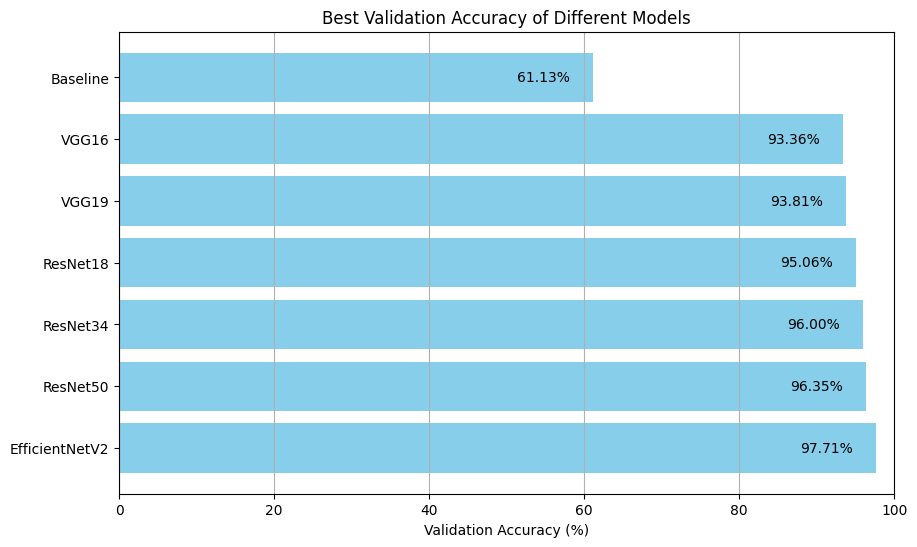

In [27]:
import matplotlib.pyplot as plt

# Model names and their corresponding best validation accuracies
models = ['EfficientNetV2', 'ResNet50', 'ResNet34', 'ResNet18', 'VGG19', 'VGG16', 'Baseline']
accuracies = [97.71, 96.35, 96.00, 95.06, 93.81, 93.36, 61.13]

# Sort models by accuracy
sorted_indices = sorted(range(len(accuracies)), key=lambda i: accuracies[i], reverse=True)
sorted_models = [models[i] for i in sorted_indices]
sorted_accuracies = [accuracies[i] for i in sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_models, sorted_accuracies, color='skyblue')
plt.xlabel('Validation Accuracy (%)')
plt.title('Best Validation Accuracy of Different Models')
plt.xlim(0, 100)  # Set x-axis limits from 0 to 100
plt.grid(axis='x')

# Annotate each bar with its accuracy inside the bar
for bar in bars:
    plt.text(bar.get_width() - 3, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%',
             va='center', ha='right', color='black', fontsize=10)

# Show plot
plt.show()
